In [2]:
import os
import sys

def is_colab():
    return 'google.colab' in sys.modules

if is_colab():
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_PATH = '/content/drive/MyDrive/MEC_Stackelberg_Project'
else:
    # 自动根据当前脚本定位项目根路径
    PROJECT_PATH = os.path.abspath(os.path.join(os.path.dirname(__file__), '..')) \
        if '__file__' in globals() else os.path.abspath(os.path.join(os.getcwd(), '..'))

if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)

print(f"项目路径设置为: {PROJECT_PATH}")

项目路径设置为: c:\Users\a1831\Desktop\MEC_Stackelberg_Project


In [3]:
import src.config as config
import src.models as models
import src.algorithms.user_game_solver as user_game_solver
import src.algorithms.Stackelberg_solver as Stackelberg_solver
import src.algorithms.baseline_solver as baseline_solver
import src.run_experiment as run_experiment
import src.utils as utils
import numpy as np
import matplotlib.pyplot as plt

SEED = 43

In [4]:
CONFIG_PATH = os.path.join(PROJECT_PATH, "configs", "base_10.json")
config = config.Config(CONFIG_PATH)

users = run_experiment.create_users(config,SEED,True)
provider = run_experiment.create_provider(config)
for user in users:
  print(user.user_id)
  user.print_bounds(1e-1,1e-1)
  user.print_costs(1e-1,1e-1)

0
 f_{thres}_ 0 = 1.8823904182590745  B_{thres}_ 0 = 3.827622483287052
 f_{hat}_ 0 = 8.824987894443755  B_{hat}_ 0 = 13.727542430103586
 C^l_ 0 = 7.0710620074382895  C_hat_e_ 0 = 4.510506064909468
 C_{hat}_ef_ 0 = 1.764997578888751  C_{hat}_eb_ 0 = 2.745508486020717
1
 f_{thres}_ 1 = 1.2443447401601482  B_{thres}_ 1 = 1.0217742693416199
 f_{hat}_ 1 = 13.633633803193309  B_{hat}_ 1 = 12.24851022965479
 C^l_ 1 = 17.511795247515767  C_hat_e_ 1 = 5.1764288065696205
 C_{hat}_ef_ 1 = 2.726726760638662  C_{hat}_eb_ 1 = 2.4497020459309584
2
 f_{thres}_ 2 = 0.7844614080490686  B_{thres}_ 2 = 0.335191702308002
 f_{hat}_ 2 = 12.024966257279342  B_{hat}_ 2 = 7.68281115547061
 C^l_ 2 = 20.048013744122855  C_hat_e_ 2 = 3.9415554825499903
 C_{hat}_ef_ 2 = 2.4049932514558683  C_{hat}_eb_ 2 = 1.536562231094122
3
 f_{thres}_ 3 = 2.1565794175577313  B_{thres}_ 3 = 5.364963179900877
 f_{hat}_ 3 = 9.646979600517012  B_{hat}_ 3 = 17.179199828017047
 C^l_ 3 = 7.966860219320041  C_hat_e_ 3 = 5.365235885706812

In [5]:
pe_or, pn_or, X_or, U_or, results_or = baseline_solver.oracle_baseline_greedy(users, provider, (1e-3,20), (1e-3,20), 500)
print("pe_oracle, pn_oracle=", pe_or, pn_or)
print(f"X_oracle={X_or}, U_oracle={U_or}")

c:\Users\a1831\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive direc

C:\Users\a1831\AppData\Local\Temp\ipykernel_31484\3699383799.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


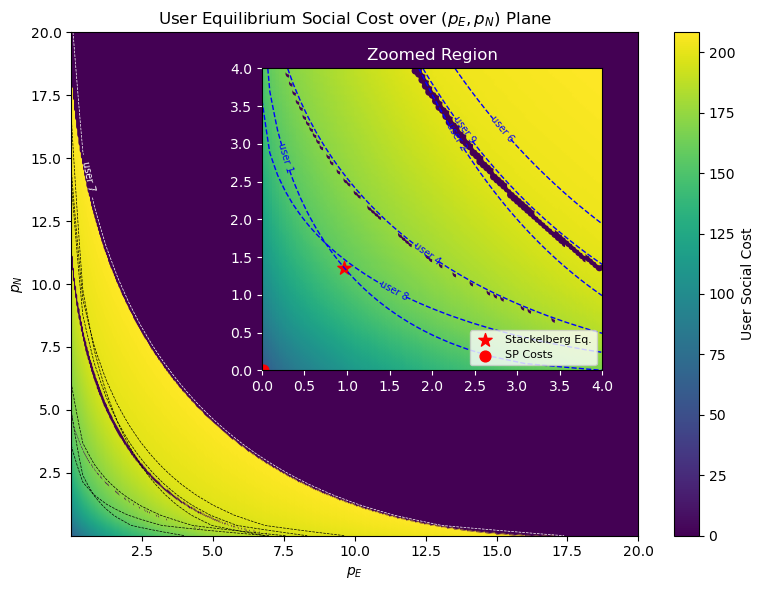

In [18]:
"""
ESP/NSP价格 vs 用户Social Cost
"""
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ======= 大图的数据准备 =======
p_E_vals = np.array([r["p_E"] for r in results_or])
p_N_vals = np.array([r["p_N"] for r in results_or])
V_vals = np.array([r["social_cost"] for r in results_or])

# ======= 小图数据准备 =======
filtered_results = [r for r in results_or if 0 <= r["p_E"] <= 4 and 0 <= r["p_N"] <= 4]
p_E_filtered = np.array([r["p_E"] for r in filtered_results])
p_N_filtered = np.array([r["p_N"] for r in filtered_results])
V_vals_filtered = np.array([r["social_cost"] for r in filtered_results])

# ======= 主图（大图） =======
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(p_E_vals, p_N_vals, c=V_vals, cmap="viridis", s=10)
ax.set_xlabel("$p_E$")
ax.set_ylabel("$p_N$")
plt.title("User Equilibrium Social Cost over $(p_E, p_N)$ Plane")
p_E_range = np.linspace(1e-3, 20, 50)
p_N_range = np.linspace(1e-3, 20, 50)
for user in users:
    if user.user_id in [0,3,5]: continue
    a, d, b, S, C_l = user.task.alpha, user.task.d, user.task.b, user.S_i, user.cost_local()
    A_i = 2*np.sqrt(a*d)
    B_i = 2*np.sqrt(a*b/S)

    P_E, P_N = np.meshgrid(p_E_range, p_N_range)
    constraint = A_i*np.sqrt(P_E) + B_i*np.sqrt(P_N)

    # 绘制轮廓线 (等于C_l的线)
    if user.user_id != 7:
        CS = plt.contour(P_E, P_N, constraint, levels=[C_l], linewidths=0.5, colors='black',linestyles='dashed')
    # plt.clabel(CS, inline=True, fontsize=5, fmt={C_l: f'user {user.user_id}'})
    
    if user.user_id == 7:
        CS = plt.contour(P_E, P_N, constraint, levels=[C_l], linewidths=0.5, colors='white',linestyles='dashed')
        plt.clabel(CS, inline=True, fontsize=7,
           fmt={C_l: f'user {user.user_id}'},
           inline_spacing=5,
           use_clabeltext=True,
           rightside_up=True)

# 添加 colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("User Social Cost")

# ======= 插图（小图） =======
inset_ax = inset_axes(ax, width="60%", height="60%", loc='upper right', borderpad=2.6)

sc2 = inset_ax.scatter(p_E_filtered, p_N_filtered, c=V_vals_filtered, cmap="viridis", s=20)

# 标注Stackelberg解与SP成本点
inset_ax.scatter([pe_or], [pn_or], color='red', marker='*', s=100, label='Stackelberg Eq.')
inset_ax.scatter([provider.c_E], [provider.c_N], color='red', marker='o', s=60, label='SP Costs')

# 绘制用户的等效成本边界曲线
p_E_range = np.linspace(1e-3, 4, 45)
p_N_range = np.linspace(1e-3, 4, 45)
P_E, P_N = np.meshgrid(p_E_range, p_N_range)
for user in users:
    if user.user_id in [0,3,5]: continue
    a, d, b, S, C_l = user.task.alpha, user.task.d, user.task.b, user.S_i, user.cost_local()
    A_i = 2*np.sqrt(a*d)
    B_i = 2*np.sqrt(a*b/S)
    constraint = A_i*np.sqrt(P_E) + B_i*np.sqrt(P_N)
    if user.user_id == 2:
        CS = inset_ax.contour(P_E, P_N, constraint, levels=[C_l], linewidths=1, colors='blue', linestyles='dashed')
        inset_ax.clabel(CS, inline=True, fontsize=7, fmt={C_l: f'user {user.user_id}'})
    else:
        CS = inset_ax.contour(P_E, P_N, constraint, levels=[C_l], linewidths=1, colors='blue', linestyles='dashed')
        inset_ax.clabel(CS, inline=True, fontsize=7, fmt={C_l: f'user {user.user_id}'})

inset_ax.set_xlim(0, 4)
inset_ax.set_ylim(0, 4)
inset_ax.tick_params(axis='both', colors='white')
inset_ax.set_title("Zoomed Region", color='white')
inset_ax.legend(fontsize=8, loc='lower right')

plt.tight_layout()
plt.show()

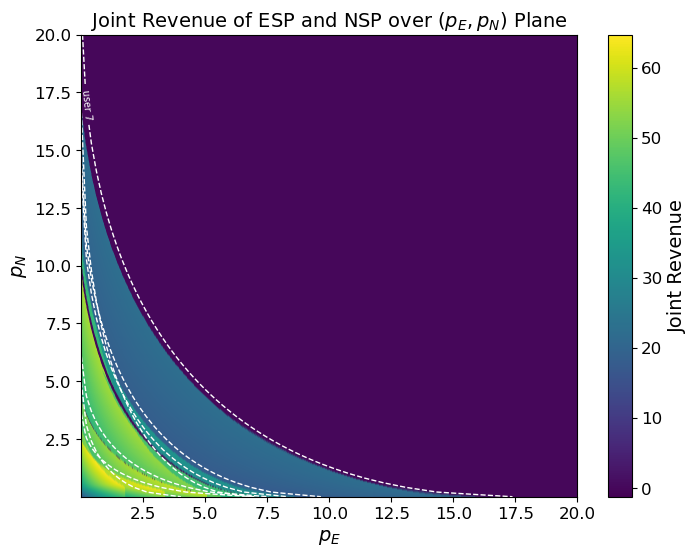

In [120]:
"""
ESP/NSP价格 vs SP总收益

"""
p_E_vals = np.array([r["p_E"] for r in results_or])
p_N_vals = np.array([r["p_N"] for r in results_or])
U_vals = np.array([r["U_X"] for r in results_or])


plt.figure(figsize=(8,6))
sc = plt.scatter(p_E_vals, p_N_vals, c=U_vals, cmap="viridis", s=50)
plt.colorbar(sc, label="Joint Revenue")

p_E_range = np.linspace(1e-3, 20, 100)
p_N_range = np.linspace(1e-3, 20, 100)
for user in users:
    if user.user_id in [0,3,5]: continue
    a, d, b, S, C_l = user.task.alpha, user.task.d, user.task.b, user.S_i, user.cost_local()
    A_i = 2*np.sqrt(a*d)
    B_i = 2*np.sqrt(a*b/S)

    P_E, P_N = np.meshgrid(p_E_range, p_N_range)
    constraint = A_i*np.sqrt(P_E) + B_i*np.sqrt(P_N)

    # 绘制轮廓线 (等于C_l的线)
    CS = plt.contour(P_E, P_N, constraint, levels=[C_l], linewidths=1, colors='white',linestyles='dashed')
    # plt.clabel(CS, inline=True, fontsize=5, fmt={C_l: f'user {user.user_id}'})
    
    if user.user_id == 7:
        plt.clabel(CS, inline=True, fontsize=7,
           fmt={C_l: f'user {user.user_id}'},
           inline_spacing=5,
           use_clabeltext=True,
           rightside_up=True)

plt.xlabel("$p_E$")
plt.ylabel("$p_N$")
plt.title("Joint Revenue of ESP and NSP over $(p_E, p_N)$ Plane")
plt.show()

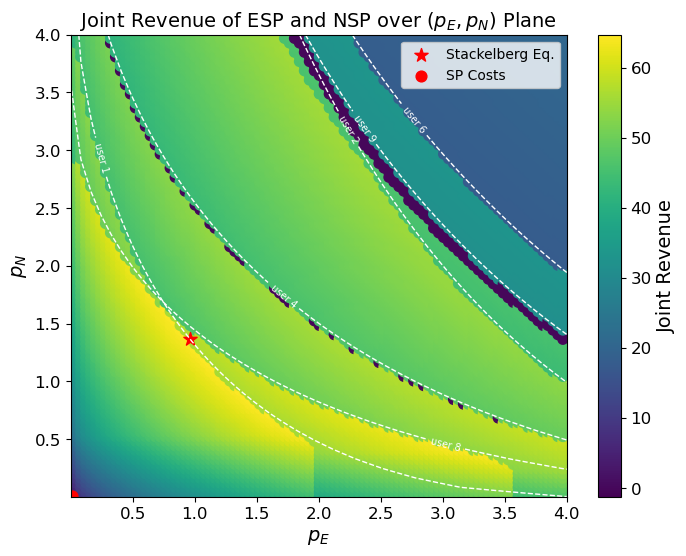

In [121]:
# 筛选出 p_E 和 p_N 均在 [0,5] 区间内的结果
filtered_results = [r for r in results_or if 0 <= r["p_E"] <= 4 and 0 <= r["p_N"] <= 4]

# 提取筛选后的价格和收益
p_E_filtered = np.array([r["p_E"] for r in filtered_results])
p_N_filtered = np.array([r["p_N"] for r in filtered_results])
U_vals_filtered = np.array([r["U_X"] for r in filtered_results])

# 绘制散点图
plt.figure(figsize=(8,6))
sc = plt.scatter(p_E_filtered, p_N_filtered, c=U_vals_filtered, cmap="viridis", s=50)
plt.colorbar(sc, label="Joint Revenue")

p_E_range = np.linspace(1e-3, 4, 50)
p_N_range = np.linspace(1e-3, 4, 50)
for user in users:
    if user.user_id in [0,3,5]: continue
    a, d, b, S, C_l = user.task.alpha, user.task.d, user.task.b, user.S_i, user.cost_local()
    A_i = 2*np.sqrt(a*d)
    B_i = 2*np.sqrt(a*b/S)

    P_E, P_N = np.meshgrid(p_E_range, p_N_range)
    constraint = A_i*np.sqrt(P_E) + B_i*np.sqrt(P_N)

    # 绘制轮廓线 (等于C_l的线)
    CS = plt.contour(P_E, P_N, constraint, levels=[C_l], linewidths=1, colors='white',linestyles='dashed')
    # plt.clabel(CS, inline=True, fontsize=5, fmt={C_l: f'user {user.user_id}'})
    
    plt.clabel(CS, inline=True, fontsize=7,
           fmt={C_l: f'user {user.user_id}'},
           inline_spacing=5,
           use_clabeltext=True,
           rightside_up=True)
    
plt.scatter([pe_or], [pn_or], color='red', marker='*', s=100, label='Stackelberg Eq.')
plt.scatter([provider.c_E], [provider.c_N], color='red', marker='o', s=60, label='SP Costs')
plt.legend(loc='upper right', fontsize=10)

# plt.rcParams.update({
#     "font.size": 12,
#     "axes.labelsize": 14,
#     "axes.titlesize": 14,
#     "xtick.labelsize": 12,
#     "ytick.labelsize": 12,
# })

# best_result = next((r for r in results_or if r["U_X"]==U_or),None)
# stack_util=best_result["U_X"]

# cbar = plt.colorbar(sc)
# cbar.set_label("Aggregate Resource Utilization", fontsize=12)
# cbar.ax.hlines(stack_util, *cbar.ax.get_xlim(), color='red', linestyle='--', linewidth=2)
# cbar.ax.annotate(
#     "SE.",
#     xy=(1.02, stack_util),
#     xytext=(1.3, stack_util - 0.1),
#     arrowprops=dict(arrowstyle="->", color="red"),
#     color="red",
#     fontsize=9,
#     ha="left", va="center"
# )

plt.xlabel("$p_E$")
plt.ylabel("$p_N$")
plt.title("Joint Revenue of ESP and NSP over $(p_E, p_N)$ Plane")
plt.show()

C:\Users\a1831\AppData\Local\Temp\ipykernel_30672\3621192853.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


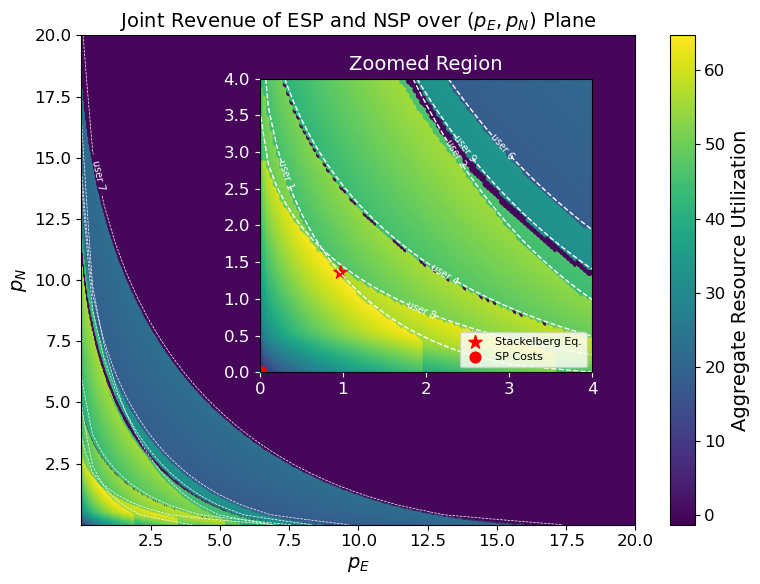

In [123]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ======= 大图的数据准备 =======
p_E_vals = np.array([r["p_E"] for r in results_or])
p_N_vals = np.array([r["p_N"] for r in results_or])
U_vals = np.array([r["U_X"] for r in results_or])

# ======= 小图数据准备 =======
filtered_results = [r for r in results_or if 0 <= r["p_E"] <= 4 and 0 <= r["p_N"] <= 4]
p_E_filtered = np.array([r["p_E"] for r in filtered_results])
p_N_filtered = np.array([r["p_N"] for r in filtered_results])
U_vals_filtered = np.array([r["U_X"] for r in filtered_results])

# ======= 主图（大图） =======
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(p_E_vals, p_N_vals, c=U_vals, cmap="viridis", s=10)
ax.set_xlabel("$p_E$")
ax.set_ylabel("$p_N$")
plt.title("Joint Revenue of ESP and NSP over $(p_E, p_N)$ Plane")
p_E_range = np.linspace(1e-3, 20, 50)
p_N_range = np.linspace(1e-3, 20, 50)
for user in users:
    if user.user_id in [0,3,5]: continue
    a, d, b, S, C_l = user.task.alpha, user.task.d, user.task.b, user.S_i, user.cost_local()
    A_i = 2*np.sqrt(a*d)
    B_i = 2*np.sqrt(a*b/S)

    P_E, P_N = np.meshgrid(p_E_range, p_N_range)
    constraint = A_i*np.sqrt(P_E) + B_i*np.sqrt(P_N)

    # 绘制轮廓线 (等于C_l的线)
    CS = plt.contour(P_E, P_N, constraint, levels=[C_l], linewidths=0.5, colors='white',linestyles='dashed')
    # plt.clabel(CS, inline=True, fontsize=5, fmt={C_l: f'user {user.user_id}'})
    
    if user.user_id == 7:
        plt.clabel(CS, inline=True, fontsize=7,
           fmt={C_l: f'user {user.user_id}'},
           inline_spacing=5,
           use_clabeltext=True,
           rightside_up=True)

# 添加 colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Aggregate Resource Utilization")

# ======= 插图（小图） =======
inset_ax = inset_axes(ax, width="60%", height="60%", loc='upper right', borderpad=2.6)

sc2 = inset_ax.scatter(p_E_filtered, p_N_filtered, c=U_vals_filtered, cmap="viridis", s=20)

# 标注Stackelberg解与SP成本点
inset_ax.scatter([pe_or], [pn_or], color='red', marker='*', s=100, label='Stackelberg Eq.')
inset_ax.scatter([provider.c_E], [provider.c_N], color='red', marker='o', s=60, label='SP Costs')

# 绘制用户的等效成本边界曲线
p_E_range = np.linspace(1e-3, 4, 40)
p_N_range = np.linspace(1e-3, 4, 40)
P_E, P_N = np.meshgrid(p_E_range, p_N_range)
for user in users:
    if user.user_id in [0,3,5]: continue
    a, d, b, S, C_l = user.task.alpha, user.task.d, user.task.b, user.S_i, user.cost_local()
    A_i = 2*np.sqrt(a*d)
    B_i = 2*np.sqrt(a*b/S)
    constraint = A_i*np.sqrt(P_E) + B_i*np.sqrt(P_N)
    CS = inset_ax.contour(P_E, P_N, constraint, levels=[C_l], linewidths=1, colors='white', linestyles='dashed')
    inset_ax.clabel(CS, inline=True, fontsize=7, fmt={C_l: f'user {user.user_id}'})

inset_ax.set_xlim(0, 4)
inset_ax.set_ylim(0, 4)
inset_ax.tick_params(axis='both', colors='white')
inset_ax.set_title("Zoomed Region", color='white')
inset_ax.legend(fontsize=8, loc='lower right')

plt.tight_layout()
plt.show()

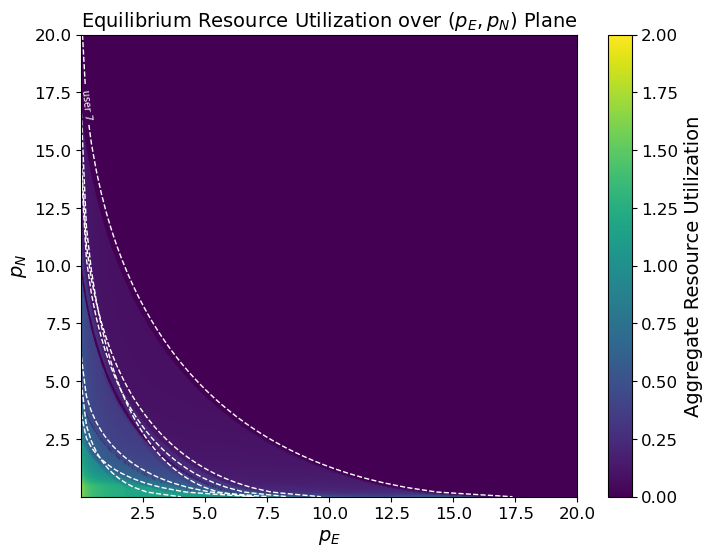

In [ ]:
"""
图2a: ESP/NSP 价格 vs. 总资源使用量
热力图
展示价格对用户资源购买量的影响
"""
# 提取价格和利用率
p_E_vals = np.array([r["p_E"] for r in results_or])
p_N_vals = np.array([r["p_N"] for r in results_or])
fb_util_vals = np.array([r["sum_f"]/provider.f_max+r["sum_b"]/provider.B_max for r in results_or])


plt.figure(figsize=(8,6))
sc = plt.scatter(p_E_vals, p_N_vals, c=fb_util_vals, cmap="viridis", s=50)
plt.colorbar(sc, label="Aggregate Resource Utilization")

p_E_range = np.linspace(1e-3, 20, 100)
p_N_range = np.linspace(1e-3, 20, 100)
for user in users:
    if user.user_id in [0,3,5]: continue
    a, d, b, S, C_l = user.task.alpha, user.task.d, user.task.b, user.S_i, user.cost_local()
    A_i = 2*np.sqrt(a*d)
    B_i = 2*np.sqrt(a*b/S)

    P_E, P_N = np.meshgrid(p_E_range, p_N_range)
    constraint = A_i*np.sqrt(P_E) + B_i*np.sqrt(P_N)

    # 绘制轮廓线 (等于C_l的线)
    CS = plt.contour(P_E, P_N, constraint, levels=[C_l], linewidths=1, colors='white',linestyles='dashed')
    # plt.clabel(CS, inline=True, fontsize=5, fmt={C_l: f'user {user.user_id}'})
    
    if user.user_id == 7:
        plt.clabel(CS, inline=True, fontsize=7,
           fmt={C_l: f'user {user.user_id}'},
           inline_spacing=5,
           use_clabeltext=True,
           rightside_up=True)

plt.xlabel("$p_E$")
plt.ylabel("$p_N$")
plt.title("Equilibrium Resource Utilization over $(p_E, p_N)$ Plane")
plt.show()

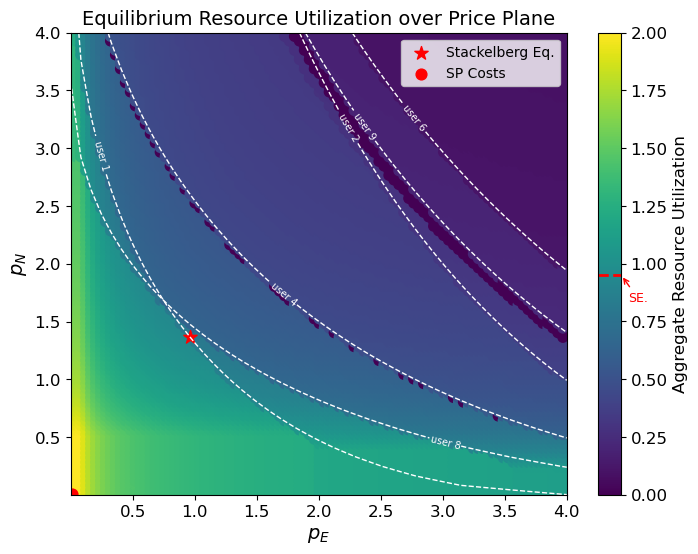

In [109]:
# 筛选出 p_E 和 p_N 均在 [0,5] 区间内的结果
filtered_results = [r for r in results_or if 0 <= r["p_E"] <= 4 and 0 <= r["p_N"] <= 4]

# 提取筛选后的价格和收益
p_E_filtered = np.array([r["p_E"] for r in filtered_results])
p_N_filtered = np.array([r["p_N"] for r in filtered_results])
fb_util_filtered = np.array([r["sum_f"]/provider.f_max + r["sum_b"]/provider.B_max for r in filtered_results])

# 绘制散点图
plt.figure(figsize=(8,6))
sc = plt.scatter(p_E_filtered, p_N_filtered, c=fb_util_filtered, s=50, vmin=0, vmax=2, cmap="viridis")
# plt.colorbar(sc, label="Resource Utilization (fb_util)")

p_E_range = np.linspace(1e-3, 4, 50)
p_N_range = np.linspace(1e-3, 4, 50)
for user in users:
    if user.user_id in [0,3,5]: continue
    a, d, b, S, C_l = user.task.alpha, user.task.d, user.task.b, user.S_i, user.cost_local()
    A_i = 2*np.sqrt(a*d)
    B_i = 2*np.sqrt(a*b/S)

    P_E, P_N = np.meshgrid(p_E_range, p_N_range)
    constraint = A_i*np.sqrt(P_E) + B_i*np.sqrt(P_N)

    # 绘制轮廓线 (等于C_l的线)
    CS = plt.contour(P_E, P_N, constraint, levels=[C_l], linewidths=1, colors='white',linestyles='dashed')
    # plt.clabel(CS, inline=True, fontsize=5, fmt={C_l: f'user {user.user_id}'})
    
    plt.clabel(CS, inline=True, fontsize=7,
           fmt={C_l: f'user {user.user_id}'},
           inline_spacing=5,
           use_clabeltext=True,
           rightside_up=True)
    
plt.scatter([pe_or], [pn_or], color='red', marker='*', s=100, label='Stackelberg Eq.')
plt.scatter([provider.c_E], [provider.c_N], color='red', marker='o', s=60, label='SP Costs')
plt.legend(loc='upper right', fontsize=10)

plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

best_result = next((r for r in results_or if r["U_X"]==U_or),None)
stack_util=best_result["sum_f"]/provider.f_max+best_result["sum_b"]/provider.B_max

cbar = plt.colorbar(sc)
cbar.set_label("Aggregate Resource Utilization", fontsize=12)
cbar.ax.hlines(stack_util, *cbar.ax.get_xlim(), color='red', linestyle='--', linewidth=2)
cbar.ax.annotate(
    "SE.",
    xy=(1.02, stack_util),
    xytext=(1.3, stack_util - 0.1),
    arrowprops=dict(arrowstyle="->", color="red"),
    color="red",
    fontsize=9,
    ha="left", va="center"
)

plt.xlabel("$p_E$")
plt.ylabel("$p_N$")
plt.title("Equilibrium Resource Utilization over Price Plane")
plt.show()

C:\Users\a1831\AppData\Local\Temp\ipykernel_30672\1310286543.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


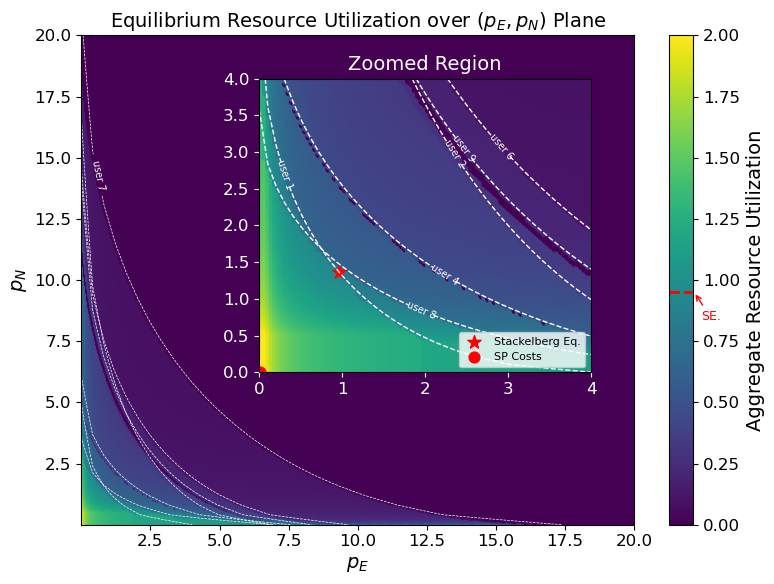

In [110]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ======= 大图的数据准备 =======
p_E_vals = np.array([r["p_E"] for r in results_or])
p_N_vals = np.array([r["p_N"] for r in results_or])
fb_util_vals = np.array([r["sum_f"]/provider.f_max + r["sum_b"]/provider.B_max for r in results_or])

# ======= 小图数据准备 =======
filtered_results = [r for r in results_or if 0 <= r["p_E"] <= 4 and 0 <= r["p_N"] <= 4]
p_E_filtered = np.array([r["p_E"] for r in filtered_results])
p_N_filtered = np.array([r["p_N"] for r in filtered_results])
fb_util_filtered = np.array([r["sum_f"]/provider.f_max + r["sum_b"]/provider.B_max for r in filtered_results])

# 找到Stackelberg均衡点的资源利用率
best_result = next((r for r in results_or if r["U_X"]==U_or), None)
stack_util = best_result["sum_f"]/provider.f_max + best_result["sum_b"]/provider.B_max

# ======= 主图（大图） =======
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(p_E_vals, p_N_vals, c=fb_util_vals, cmap="viridis", s=10)
ax.set_xlabel("$p_E$")
ax.set_ylabel("$p_N$")
ax.set_title("Equilibrium Resource Utilization over $(p_E, p_N)$ Plane")
p_E_range = np.linspace(1e-3, 20, 50)
p_N_range = np.linspace(1e-3, 20, 50)
for user in users:
    if user.user_id in [0,3,5]: continue
    a, d, b, S, C_l = user.task.alpha, user.task.d, user.task.b, user.S_i, user.cost_local()
    A_i = 2*np.sqrt(a*d)
    B_i = 2*np.sqrt(a*b/S)

    P_E, P_N = np.meshgrid(p_E_range, p_N_range)
    constraint = A_i*np.sqrt(P_E) + B_i*np.sqrt(P_N)

    # 绘制轮廓线 (等于C_l的线)
    CS = plt.contour(P_E, P_N, constraint, levels=[C_l], linewidths=0.5, colors='white',linestyles='dashed')
    # plt.clabel(CS, inline=True, fontsize=5, fmt={C_l: f'user {user.user_id}'})
    
    if user.user_id == 7:
        plt.clabel(CS, inline=True, fontsize=7,
           fmt={C_l: f'user {user.user_id}'},
           inline_spacing=5,
           use_clabeltext=True,
           rightside_up=True)

# 添加 colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Aggregate Resource Utilization")

# ======= 插图（小图） =======
inset_ax = inset_axes(ax, width="60%", height="60%", loc='upper right', borderpad=2.6)

sc2 = inset_ax.scatter(p_E_filtered, p_N_filtered, c=fb_util_filtered, cmap="viridis", s=20, vmin=0, vmax=2)

# 标注Stackelberg解与SP成本点
inset_ax.scatter([pe_or], [pn_or], color='red', marker='*', s=100, label='Stackelberg Eq.')
inset_ax.scatter([provider.c_E], [provider.c_N], color='red', marker='o', s=60, label='SP Costs')

# 绘制用户的等效成本边界曲线
p_E_range = np.linspace(1e-3, 4, 40)
p_N_range = np.linspace(1e-3, 4, 40)
P_E, P_N = np.meshgrid(p_E_range, p_N_range)
for user in users:
    if user.user_id in [0,3,5]: continue
    a, d, b, S, C_l = user.task.alpha, user.task.d, user.task.b, user.S_i, user.cost_local()
    A_i = 2*np.sqrt(a*d)
    B_i = 2*np.sqrt(a*b/S)
    constraint = A_i*np.sqrt(P_E) + B_i*np.sqrt(P_N)
    CS = inset_ax.contour(P_E, P_N, constraint, levels=[C_l], linewidths=1, colors='white', linestyles='dashed')
    inset_ax.clabel(CS, inline=True, fontsize=7, fmt={C_l: f'user {user.user_id}'})

inset_ax.set_xlim(0, 4)
inset_ax.set_ylim(0, 4)
inset_ax.tick_params(axis='both', colors='white')
inset_ax.set_title("Zoomed Region", color='white')
inset_ax.legend(fontsize=8, loc='lower right')
# 坐标轴标签颜色也改为白色（可选）
inset_ax.xaxis.label.set_color('white')
inset_ax.yaxis.label.set_color('white')


# 添加 colorbar 中 Stackelberg 点的标注
cbar.ax.hlines(stack_util, *cbar.ax.get_xlim(), color='red', linestyle='--', linewidth=2)
cbar.ax.annotate(
    "SE.",
    xy=(1.02, stack_util),
    xytext=(1.3, stack_util - 0.1),
    arrowprops=dict(arrowstyle="->", color="red"),
    color="red",
    fontsize=9,
    ha="left", va="center"
)

plt.tight_layout()
plt.show()

Thresholds: fthres=1.5122, Bthres=1.5122


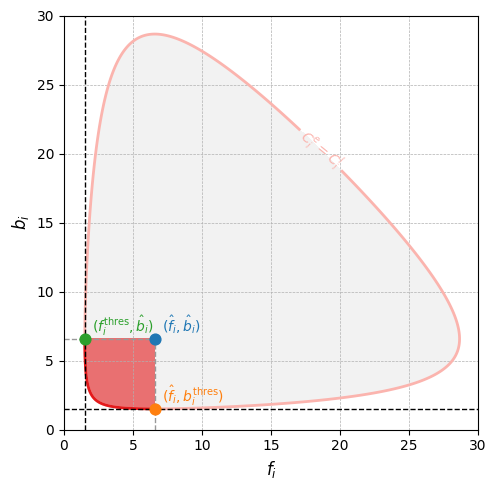

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 参数定义
alpha_i = 13
d_i = 30
b_i = 30
S_i = 1
p_E = 9
p_N = 9
fl_i = 1
Cl_i = alpha_i * d_i / fl_i

# 计算最优点和阈值点
hatf = np.sqrt(alpha_i * d_i / p_E)
hatB = np.sqrt(alpha_i * b_i / (S_i * p_N))
hatCf = 2 * np.sqrt(alpha_i * d_i * p_E)
hatCB = 2 * np.sqrt(alpha_i * b_i * p_N / S_i)

fthres = ((Cl_i - hatCB) - np.sqrt((Cl_i - hatCB)**2 - hatCf**2)) / (2 * p_E)
Bthres = ((Cl_i - hatCf) - np.sqrt((Cl_i - hatCf)**2 - hatCB**2)) / (2 * p_N)
print(f"Thresholds: fthres={fthres:.4f}, Bthres={Bthres:.4f}")

# 创建函数
def cost_func(f, B):
    return alpha_i * d_i / f + alpha_i * b_i / (S_i * B) + p_E * f + p_N * B - Cl_i

# 网格数据
x = np.linspace(0.1, 30, 400)
y = np.linspace(0.1, 30, 400)
X, Y = np.meshgrid(x, y)
Z = cost_func(X, Y)

# 图示
fig, ax = plt.subplots(figsize=(6, 5))

# 等高线 (C^e_i = C^l_i)
contour = ax.contour(X, Y, Z, levels=[0], colors='#fbb4ae', linewidths=2)
ax.clabel(contour, inline=True, fontsize=10, fmt={0: r'$C^e_i = C^l_i$'})
ax.contourf(X, Y, Z, levels=[-1000, 0], colors=['grey'], alpha=0.1)

# 内部红色区域
ICx = np.linspace(fthres, hatf, 300)
ICy = np.linspace(Bthres, hatB, 300)
ICX, ICY = np.meshgrid(ICx, ICy)
ICZ = cost_func(ICX, ICY)
ax.contour(ICX, ICY, ICZ, levels=[0], colors='#e41a1c', linewidths=2)
ax.contourf(ICX, ICY, ICZ, levels=[-1000, 0], colors=['#e41a1c'], alpha=0.6)  # 内部扇形填充


# 标记关键点
points = {
    r'$(\hat{f}_i, \hat{b}_i)$': (hatf, hatB),
    r'$(\hat{f}_i, b_i^{\mathrm{thres}})$': (hatf, Bthres),
    r'$(f_i^{\mathrm{thres}}, \hat{b}_i)$': (fthres, hatB),
}

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # 蓝色, 橙色, 绿色
for (label, (x_pt, y_pt)), c in zip(points.items(), colors):
    ax.scatter(x_pt, y_pt, color=c, s=60, zorder=5)
    ax.text(x_pt + 0.5, y_pt + 0.5, label, fontsize=10, color=c)

# 完整的切线（阈值线）
ax.axvline(x=fthres, color='black', linestyle='--', linewidth=1)
ax.axhline(y=Bthres, color='black', linestyle='--', linewidth=1)
ax.axvline(x=hatf, ymin=0, ymax=hatB/30, color='#999999', linestyle='--', linewidth=1)
ax.axhline(y=hatB, xmin=0, xmax=hatf/30, color='#999999', linestyle='--', linewidth=1)

# 坐标轴和标题修饰
ax.set_xlim(0, 30)
ax.set_ylim(0, 30)
ax.set_xlabel('$f_i$', fontsize=12)
ax.set_ylabel('$b_i$', fontsize=12)
ax.grid(True, linestyle='--', linewidth=0.5)
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()
